In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
# Network
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

In [3]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=250):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_losses, val_losses

In [4]:
def run_batches(device):

    batch_sizes = [16, 32, 64]
    train_losses_dict, val_losses_dict = {}, {}

    for batch_size in batch_sizes:
        print(f"\nRunning batch size: {batch_size}")

        # Datasets
        transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
        train_datasets = datasets.MNIST(root="./data",
                                        train=True,
                                        download=True,
                                        transform=transform)

        test_datasets = datasets.MNIST(root="./data",
                                        train=False,
                                        download=True,
                                        transform=transform)

        train_size = int(0.8 * len(train_datasets))
        val_size = len(train_datasets) - train_size
        train_subset, val_subset = random_split(train_datasets, [train_size, val_size])

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Test data
        test_loader = DataLoader(test_datasets, batch_size=batch_size, shuffle=False)

        model = ANN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.1)

        train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, device, 250)

        train_losses_dict[batch_size] = train_losses
        val_losses_dict[batch_size] = val_losses

        # Save the trained model
        model_path = f"model_batch_{batch_size}.pth"
        torch.save(model.state_dict(), model_path)

    # Loss curves plot
    plt.figure(figsize=(10, 5))
    for batch in train_losses_dict:
        plt.plot(range(1, len(train_losses_dict[batch]) + 1), train_losses_dict[batch], label=f"Train - {batch}")
        plt.plot(range(1, len(val_losses_dict[batch]) + 1), val_losses_dict[batch], linestyle='dashed', label=f"Val - {batch}")

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training loss vs validation loss based on batch sizes')
    plt.show()

    # Predictions on first 10 test images
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    def denormalize(image_tensor):
        return image_tensor * 0.5 + 0.5

    fig, axes = plt.subplots(len(batch_sizes), 10, figsize=(15, len(batch_sizes) * 2.5))

    for i, b in enumerate(batch_sizes):
        model = ANN().to(device)
        model.load_state_dict(torch.load(f"model_batch_{b}.pth"))
        model.eval()

        with torch.no_grad():
            outputs = model(images)
            predictions = outputs.argmax(1)

        for j in range(10):
            ax = axes[i, j] if len(batch_sizes) > 1 else axes[j]
            img = denormalize(images[j].cpu().squeeze(0))
            ax.imshow(img, cmap="gray")
            ax.axis('off')
            ax.set_title(f"Pred: {predictions[j].item()}\nActual: {labels[j].item()}", fontsize=8)

        # Model name as row title
        fig.text(0.02, 1 - (i + 0.6) / len(batch_sizes), f"Model: {b}",
                fontsize=12, fontweight='bold', va='center', ha='left')

plt.suptitle("Predictions for First 10 Test Images for Each Batch Size", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0.05, 0, 1, 0.98])
plt.show()

<Figure size 640x480 with 0 Axes>

Using device: cpu

Running batch size: 16
Epoch 1: Train Loss: 0.3458, Train Acc: 0.8891, Val Loss: 0.1879, Val Acc: 0.9410
Epoch 2: Train Loss: 0.1472, Train Acc: 0.9537, Val Loss: 0.1407, Val Acc: 0.9605
Epoch 3: Train Loss: 0.1082, Train Acc: 0.9653, Val Loss: 0.1130, Val Acc: 0.9649
Epoch 4: Train Loss: 0.0872, Train Acc: 0.9718, Val Loss: 0.1067, Val Acc: 0.9691
Epoch 5: Train Loss: 0.0711, Train Acc: 0.9772, Val Loss: 0.1038, Val Acc: 0.9698
Epoch 6: Train Loss: 0.0579, Train Acc: 0.9808, Val Loss: 0.0991, Val Acc: 0.9725
Epoch 7: Train Loss: 0.0510, Train Acc: 0.9832, Val Loss: 0.1218, Val Acc: 0.9643
Epoch 8: Train Loss: 0.0437, Train Acc: 0.9852, Val Loss: 0.0934, Val Acc: 0.9748
Epoch 9: Train Loss: 0.0364, Train Acc: 0.9877, Val Loss: 0.1063, Val Acc: 0.9712
Epoch 10: Train Loss: 0.0339, Train Acc: 0.9889, Val Loss: 0.0950, Val Acc: 0.9764
Epoch 11: Train Loss: 0.0304, Train Acc: 0.9895, Val Loss: 0.1268, Val Acc: 0.9716
Epoch 12: Train Loss: 0.0261, Train Acc: 0.9910, Val L

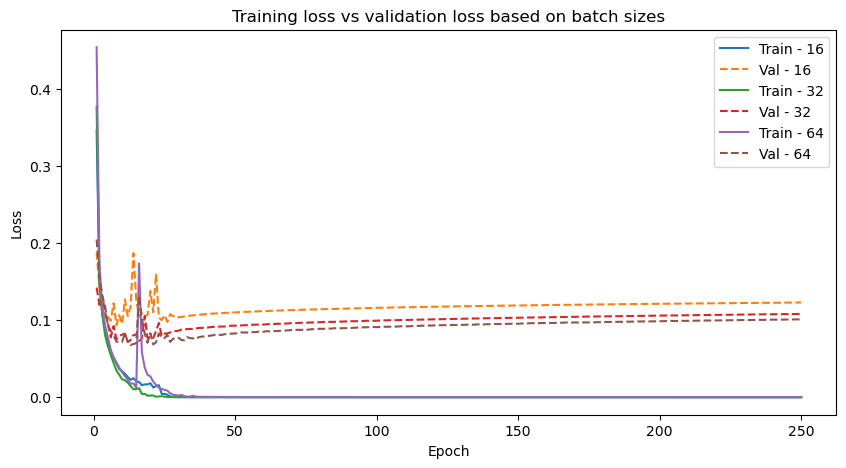

C:\Users\johna\AppData\Local\Temp\ipykernel_40408\1193151910.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"model_batch_{b}.pth"))


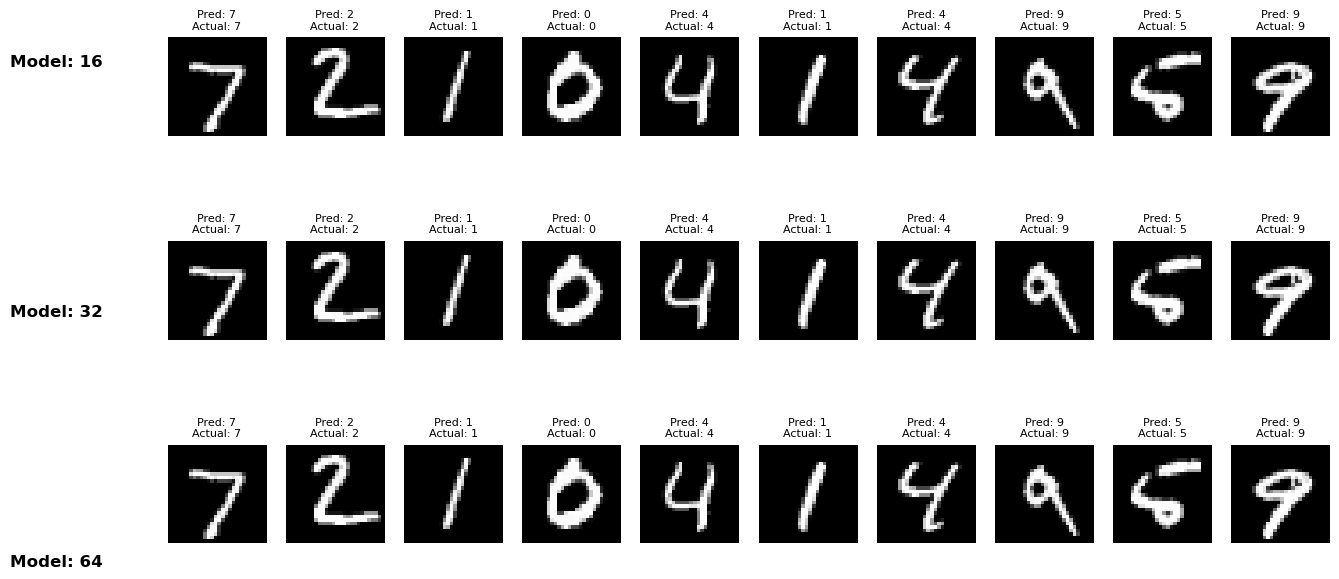

In [5]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    run_batches(device)